In [121]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [122]:
import re

fn = "5369_26_2p_alpha_45.txt"
with open(fn, "r") as f:
    lines = f.readlines()

# 0 row is Field, V, alternating
# 1 is the unit
# 2 row is some text data 
# 3 onwards is the data, in N pairs of columns
info_data = lines[2].split("\t")
# freqs = 
data = [l.replace("\n", "").split("\t") for l in lines[3:] if l != "\n"]
data = np.asarray(data, np.float32).T
lines = [l for l in lines if l != "\n"]

In [123]:
import re
from itertools import repeat

rgx = re.compile(
    r'(Vb_-?[0-9]+_mV)(.+)(f_[0-9]+\.[0-9]+_GHz)(.+)(A_-?[0-9]+_d)')
vfas = []

df = None
if len(info_data) % 2 != 0:
    raise ValueError("Columns invalid, not in pairs")
Hf_map = []
f_indx = []
H_series = []
for i in range(len(info_data) // 2):
    info = info_data[i * 2]
    print(info)
    m = rgx.search(info)
    v = m.group(1).replace("Vb_", "").replace("_mV", "")
    f = m.group(3).replace("f_", "").replace("_GHz", "")
    ang = m.group(5).replace("A_", "").replace("_d", "")

    H = data[2 * i, :]
    V = data[(2 * i) + 1, :]
    Hf_map.append(V.tolist())
    f_indx.append(float(f))
    H_series.append(H)
    tdf = pd.DataFrame.from_dict({
        "V": V,
        "H": H,
        "Vb": repeat(float(v), len(H)),
        "f": repeat(float(f), len(H)),
        "ang": repeat(float(ang), len(H))
    })
    if df is None:
        df = tdf
    else:
        df = pd.concat([df, tdf], ignore_index=True)

Hf_map = np.asarray(Hf_map)

5369_26_2p__V-FMR_Vb_100_mV_P_-10_dBm_f_1.0_GHz__A_45_d_P_-3_d
5369_26_2p__V-FMR_Vb_100_mV_P_-10_dBm_f_2.0_GHz__A_45_d_P_-3_d
5369_26_2p__V-FMR_Vb_100_mV_P_-10_dBm_f_3.0_GHz__A_45_d_P_-3_d
5369_26_2p__V-FMR_Vb_100_mV_P_-10_dBm_f_4.0_GHz__A_45_d_P_-3_d
5369_26_2p__V-FMR_Vb_100_mV_P_-10_dBm_f_5.0_GHz__A_45_d_P_-3_d
5369_26_2p__V-FMR_Vb_100_mV_P_-10_dBm_f_6.0_GHz__A_45_d_P_-3_d
5369_26_2p__V-FMR_Vb_100_mV_P_-10_dBm_f_7.0_GHz__A_45_d_P_-3_d
5369_26_2p__V-FMR_Vb_100_mV_P_-10_dBm_f_8.0_GHz__A_45_d_P_-3_d
5369_26_2p__V-FMR_Vb_100_mV_P_-10_dBm_f_9.0_GHz__A_45_d_P_-3_d


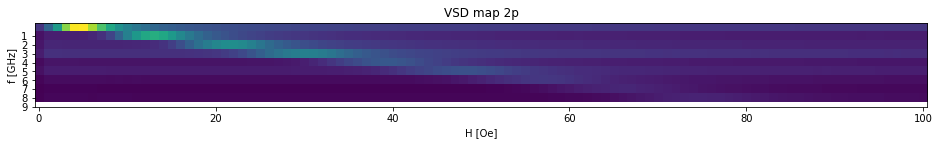

In [124]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.imshow(np.asarray(Hf_map))
ax.set_xlabel("H [Oe]")
ax.set_ylabel("f [GHz]")
_ = ax.set_yticks(f_indx)
_ = ax.set_title("VSD map 2p")

0.28670897658780686


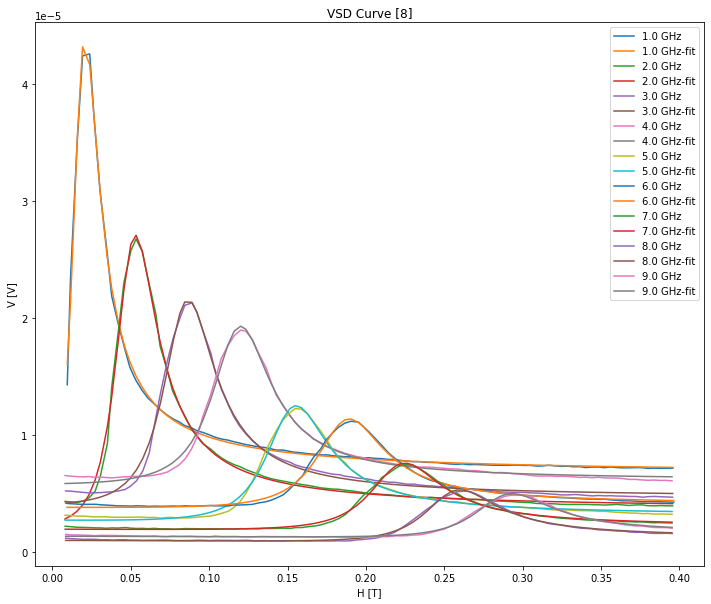

In [176]:
from scipy.optimize import curve_fit

MU = 12.57e-7
GYRO = 221000
GYRO_ = GYRO / (2 * np.pi)
TtoAm = 795774.715459


def lorentz_fit(H, dH, Hr, Va, Vs, Vb):
    dH2 = (dH**2)
    HHr = H - Hr
    d1 = (HHr**2 + dH2)
    denom = 4 * (HHr**2) + dH2
    nom = Va * HHr * dH + Vs * dH2
    return Vb + nom / denom

fig, ax = plt.subplots(figsize=(12, 10))
for indx, f in enumerate(frequencies):
    # Oe to A/m
    H_ = H_series[indx] * 1000 / (4 * np.pi) / TtoAm

    start = 1
    popt, pcov = curve_fit(lorentz_fit,
                           xdata=H_[start:],
                           ydata=Hf_map[indx, start:],
                           p0=(0.1, 0.12, 0, 0, 0))
    ax.plot(H_[1:], Hf_map[indx, 1:], label=f"{f/1e9} GHz")
    ax.plot(H_[1:], lorentz_fit(H_[1:], *popt), label=f"{f/1e9} GHz-fit")
    ax.set_xlabel("H [T]")
    ax.set_ylabel("V [V]")
    _ = ax.set_title(f"VSD Curve [{indx}]")

ax.legend()
print(popt[1])  # Hr

In [180]:
for h in H_series:
    print(h[0], h[-1])

51.5 3957.9
52.2 3956.6
52.3 3956.9
52.5 3952.9
52.6 3953.2
52.5 3963.7
52.6 3952.6
52.5 3952.8
52.5 3953.2


In [131]:
def fit_curve_range(H_series, H_map, i_start=1):
    Hrs = []
    for h_indx, H_s in enumerate(H_series):
        H_T = H_s[i_start:] * 1000 / (4 * np.pi) / TtoAm
        popt, pcov = curve_fit(lorentz_fit,
                               xdata=H_T,
                               ydata=H_map[h_indx, i_start:],
                               p0=(0.1, 0.12, 0, 0, 0))
        dH, Hr, Va, Vs, Vb = popt
        Hrs.append(Hr)
    return Hrs

org_Hrs = fit_curve_range(H_series, Hf_map)

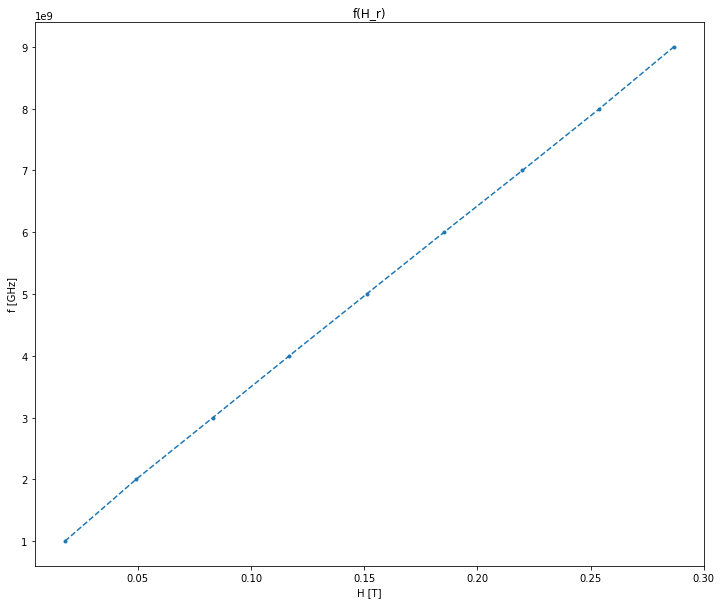

In [132]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(org_Hrs, np.arange(1, 10)*1e9, '--.')
ax.set_xlabel("H [T]")
ax.set_ylabel("f [GHz]")
_ = ax.set_title(f"f(H_r)")

In [230]:
np.arange(0, len(H_series[0])), H_series[0]

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100]),
 array([  51.5,   94.7,  116. ,  158.3,  192.4,  238.1,  265.5,  303.7,
         347.5,  378.4,  423.7,  463.6,  494.6,  532.5,  572.7,  609. ,
         651.2,  691.1,  731. ,  771.1,  811.8,  843.4,  889.9,  921.2,
         961.6,  999.3, 1036.5, 1075.8, 1117.4, 1157.7, 1193. , 1232.6,
        1273.5, 1314. , 1361.6, 1388.6, 1428.5, 1468.9, 1516.5, 1546.2,
        1590.2, 1625.6, 1666.4, 1707.2, 1755.2, 1788. , 1828.8, 1864.

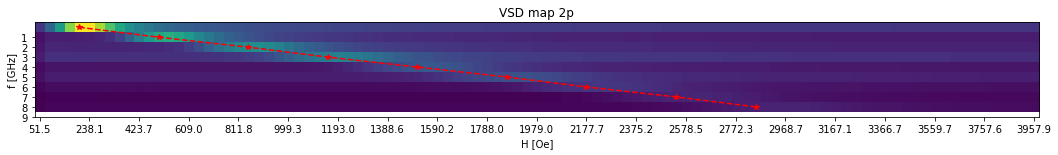

In [236]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


# convert back to the Oe
Hrs2 = np.asarray(org_Hrs)*TtoAm*(4*np.pi)/1000
Hrs_ = [find_nearest(H_s, H) for H_s, H in zip(H_series, Hrs2)] 


fig, ax = plt.subplots(figsize=(18, 14))
ax.imshow(np.asarray(Hf_map))
ax.plot(Hrs_, range(Hf_map.shape[0]), 'r--*')
ax.set_xlabel("H [Oe]")
ax.set_ylabel("f [GHz]")
ax.set_xticks(np.arange(0, len(H_series[0]))[::5])
ax.set_xticklabels(H_series[0][::5])
_ = ax.set_yticks(f_indx)
_ = ax.set_title("VSD map 2p")

In [134]:
MU = 12.57e-7
GYRO = 221000
GYRO_ = GYRO/(2*np.pi)#28024.95164
TtoAm = 795774.715459

def Kittel_Ku(H, Ms, Ku):
    return GYRO_ * np.sqrt((MU * H + MU * Ms) * (MU * H - 2 * Ku / Ms))


def Kittel_FMR(H, Ms):
    B = MU * H
    MS = MU * Ms
    return GYRO_ * np.sqrt(B * (B + MS))


# T
H_kittel = np.array(org_Hrs)*TtoAm
popt, pcov = curve_fit(Kittel_Ku,
                       method='trf',
                       xdata=H_kittel,
                       ydata=np.arange(1, 10) * 1e9,
                       check_finite=True, 
                       p0=(1e6, 1e3),
                       bounds=[(0, 0), (np.inf, np.inf)])
Ms, Ku = popt
print(Ms, Ku)

1.3098236516120382e+17 0.001572094542780178


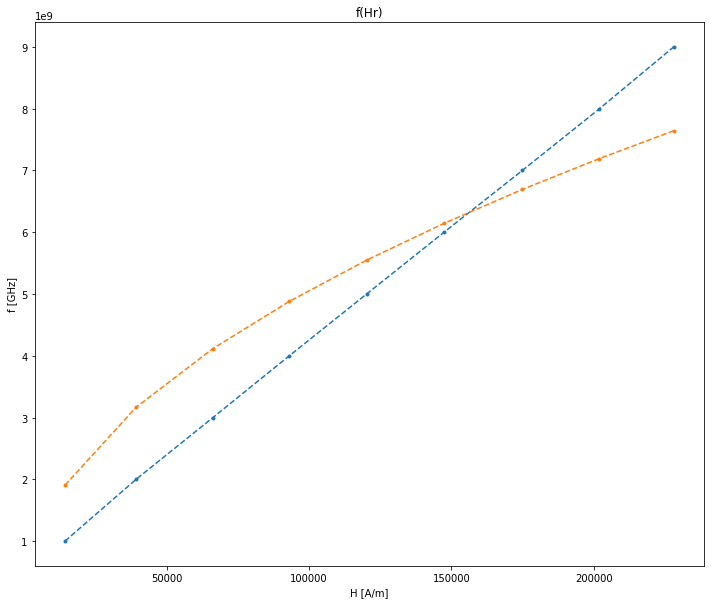

In [130]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(H_kittel, np.arange(1, 10)*1e9, '--.')
ax.plot(H_kittel, Kittel_Ku(H_kittel, Ms, Ku), '--.')
ax.set_xlabel("H [A/m]")
ax.set_ylabel("f [GHz]")
_ = ax.set_title(f"f(Hr)")

In [217]:
from cmtj import Junction, Layer, CVector, Axis, ScalarDriver, AxialDriver, NullDriver
from tqdm.notebook import tqdm
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt

TtoAm = 795774.715459


def compute_magnetoresistance(simulation_log,
                              Rx0,
                              Ry0,
                              AMR,
                              SMR,
                              AHE,
                              ratio=3 / 2):
    mx = np.asarray(simulation_log["free_mx"])
    my = np.asarray(simulation_log["free_my"])
    mz = np.asarray(simulation_log["free_mz"])
    Rx = Rx0 + AMR * np.power(mx, 2) + SMR * np.power(my, 2)
    Ry = Ry0 + 0.5 * AHE * mz + (-ratio * AMR + ratio * SMR) * mx * my
    return Rx, Ry


def compute_VSD(simulation_log, frequency, power, offset=0):
    Rx, _ = compute_magnetoresistance(simulation_log,
                                      Rx0=100,
                                      Ry0=0,
                                      AMR=10,
                                      SMR=0,
                                      AHE=0)
    avg_res = np.mean(Rx[len(Rx) // 2])
    current = np.sqrt(power / avg_res) * np.sin(
        2 * np.pi * frequency * np.asarray(simulation_log['time']) + offset)
    return np.mean(Rx * current)


H_range = (50, 3.96e3)  # Oe
H_steps = 50
H_vals = np.linspace(start=H_range[0],
                     stop=H_range[1],
                     num=H_steps,
                     endpoint=True)
# convert to A/m
H_vals = H_vals * 1000 / (4 * np.pi)
frequencies = np.arange(1, 10) * 1e9


def compute_VSD_curves(frequencies, H_vals, Ms=0.3 * TtoAm, Ku=10e3, Hoe=5e3):
    demagTensor = [
        CVector(0., 0., 0.),
        CVector(0., 0., 0.),
        CVector(0., 0., 1)
    ]
    dipoleTensor = [
        CVector(0., 0., 0.),
        CVector(0., 0., 0.),
        CVector(0., 0., 0.)
    ]

    l1 = Layer(
        id="free",
        mag=CVector(0., 0., 1.),
        anis=CVector(1., 0., 0.),
        Ms=Ms,
        thickness=1.4e-9,
        cellSurface=7e-10 * 7e-10,
        damping=0.035,
        demagTensor=demagTensor,
        dipoleTensor=dipoleTensor,
    )

    junction = Junction([l1],
                        "test.csv",
                        Rx0=[100, 100],
                        Ry0=[0.0, 0.0],
                        AMR=[10, 10],
                        SMR=[0.0, 0.0],
                        AHE=[0.0, 0.0])
    junction.setLayerAnisotropyDriver("free",
                                      ScalarDriver.getConstantDriver(Ku))

    freq_sets = []
    for freq in frequencies:
        vsd_sets = []
        for H in H_vals:
            junction.clearLog()
            junction.setLayerOerstedFieldDriver(
                "free",
                AxialDriver([
                    NullDriver(),
                    ScalarDriver.getSineDriver(0, Hoe, freq, 0),
                    NullDriver()
                ]))
            junction.setLayerExternalFieldDriver(
                "free",
                AxialDriver([
                    ScalarDriver.getConstantDriver(H * np.sqrt(2) / 2),
                    ScalarDriver.getConstantDriver(H * np.sqrt(2) / 2),
                    NullDriver()
                ]))
            junction.runSimulation(15e-9, 1e-12, 1e-12, persist=False)
            log = junction.getLog()
            vsd = compute_VSD(log, frequency=freq, power=1)
            vsd_sets.append(vsd)
        freq_sets.append(vsd_sets)

    return freq_sets


freq_sets = compute_VSD_curves(frequencies, H_vals, Ku=10e3, Hoe=50e2)

Text(0, 0.5, 'Vmix [V]')

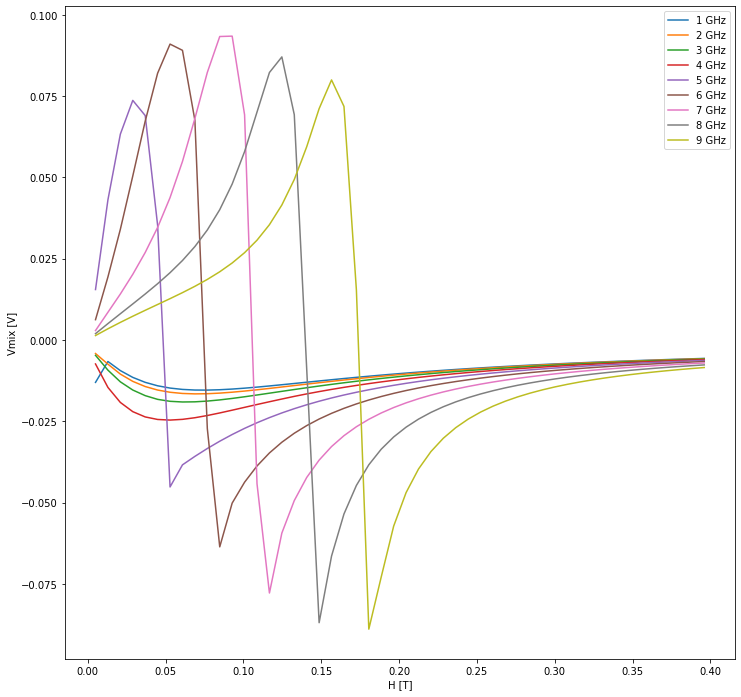

In [218]:
fig, ax = plt.subplots(figsize=(12, 12))
for f_plot, f in zip(freq_sets, frequencies):
    ax.plot(H_vals/TtoAm, f_plot, label=f"{f/1e9:.0f} GHz")
ax.legend()
ax.set_xlabel("H [T]")
ax.set_ylabel("Vmix [V]")

In [220]:
from bayes_opt import SequentialDomainReductionTransformer
from bayes_opt import BayesianOptimization
from functools import partial
import time as tm 


H_range = (50, 3.96e3)  # Oe
H_steps = 50
H_vals = np.linspace(start=H_range[0],
                     stop=H_range[1],
                     num=H_steps,
                     endpoint=True)
# convert to A/m
H_vals = H_vals * 1000 / (4 * np.pi)
frequencies = np.arange(1, 10) * 1e9


def find_MSE(org_curve, frequencies, H_vals, Ku, Ms):
    freq_sets = compute_VSD_curves(frequencies, H_vals, Ku=Ku, Ms=Ms)
    try:
        Hrs = fit_curve_range_sim(H_vals/TtoAm, freq_sets)
    except:
        return -999999999
    Hrs = np.asarray(Hrs)
    return -np.sum(np.power(Hrs-org_curve, 2))


pbounds = {
    'Ms': (0.3*TtoAm, 2*TtoAm),
    'Ku': (1, 600e3)
}


opt_fn = partial(find_MSE,
    org_curve=org_Hrs,
    frequencies=frequencies,
    H_vals=H_vals
)

start = tm.time()
bounds_transformer = SequentialDomainReductionTransformer()
optimizer = BayesianOptimization(opt_fn,
                                 pbounds,
                                 bounds_transformer=bounds_transformer,
                                 random_state=42)
optimizer.maximize(init_points=10, n_iter=90)
end = tm.time()
print(f"Optimisation lasted: {end-start:.2f}")

|   iter    |  target   |    Ku     |    Ms     |
-------------------------------------------------
|  1        | -1e+09    |  2.247e+0 |  1.525e+0 |
|  2        | -1e+09    |  4.392e+0 |  1.049e+0 |
|  3        | -0.8915   |  9.361e+0 |  4.498e+0 |
|  4        | -1e+09    |  3.485e+0 |  1.411e+0 |
|  5        | -1e+09    |  3.607e+0 |  1.197e+0 |
|  6        | -0.2092   |  1.235e+0 |  1.551e+0 |
|  7        | -1e+09    |  4.995e+0 |  5.26e+05 |
|  8        | -0.6704   |  1.091e+0 |  4.868e+0 |
|  9        | -1e+09    |  1.825e+0 |  9.486e+0 |
|  10       | -1e+09    |  2.592e+0 |  6.327e+0 |
|  11       | -0.326    |  6.931e+0 |  1.592e+0 |
|  12       | -0.3458   |  7.501e+0 |  1.476e+0 |
|  13       | -0.3594   |  8.273e+0 |  1.532e+0 |
|  14       | -0.3372   |  7.351e+0 |  1.481e+0 |
|  15       | -0.1999   |  1.0      |  1.592e+0 |
|  16       | -0.2746   |  4.103e+0 |  1.571e+0 |
|  17       | -0.1971   |  809.1    |  1.52e+06 |
|  18       | -0.1968   |  779.8    |  1.512e+0 |


KeyboardInterrupt: 

In [221]:
optimizer.max

{'target': -0.19006894595178683,
 'params': {'Ku': 5.841630943261125, 'Ms': 1385850.8649227377}}

4.891

In [222]:
freq_sets = compute_VSD_curves(frequencies,
                               H_vals,
                               Ku=optimizer.max['params']['Ku'],
                               Ms=optimizer.max['params']['Ms'])

Text(0, 0.5, 'Vmix [V]')

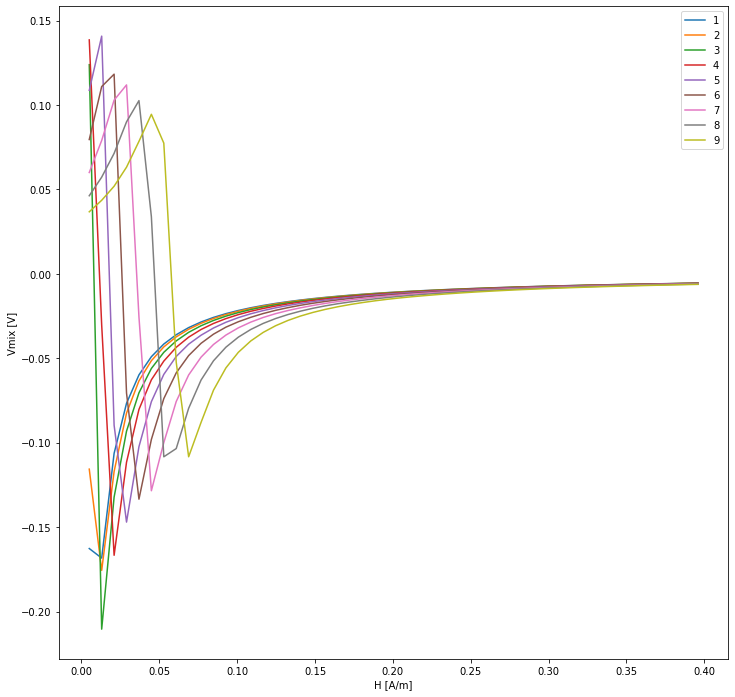

In [223]:
fig, ax = plt.subplots(figsize=(12, 12))
for f_plot, f in zip(freq_sets, frequencies):
    ax.plot(H_vals/TtoAm, f_plot, label=f"{f/1e9:.0f}")
ax.legend()
ax.set_xlabel("H [A/m]")
ax.set_ylabel("Vmix [V]")

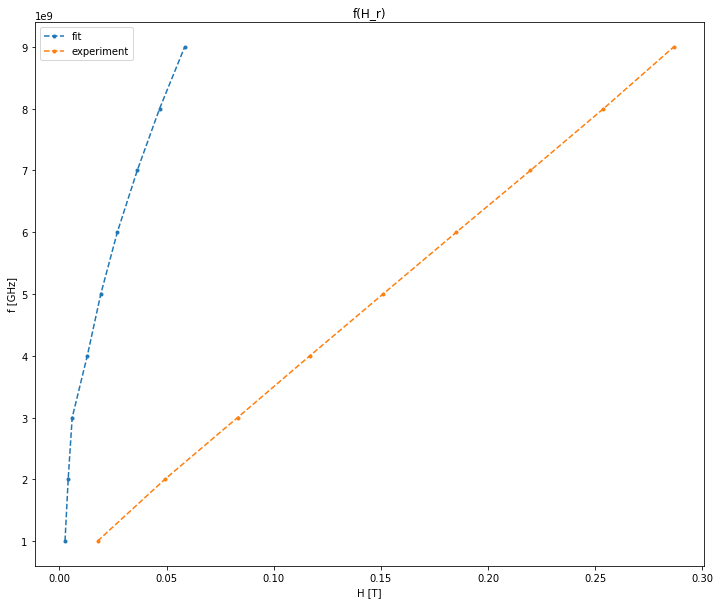

In [224]:
Hrs = fit_curve_range_sim(H_vals/TtoAm, freq_sets)
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(Hrs, np.arange(1, 10) * 1e9, '--.', label='fit')
ax.plot(org_Hrs, np.arange(1, 10) * 1e9, '--.', label='experiment')
ax.set_xlabel("H [T]")
ax.set_ylabel("f [GHz]")
ax.legend()
_ = ax.set_title(f"f(H_r)")

/usr/local/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


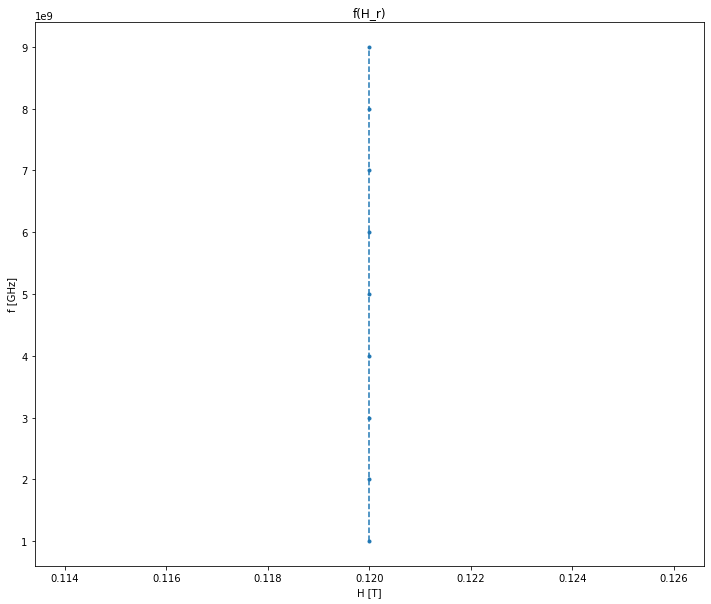

In [111]:
from scipy.optimize import curve_fit 

MU = 12.57e-7
GYRO = 221000
GYRO_ = GYRO / (2 * np.pi)
TtoAm = 795774.715459


def lorentz_fit(H, dH, Hr, Va, Vs, Vb):
    dH2 = (dH**2)
    HHr = H - Hr
    d1 = (HHr**2 + dH2)
    denom = 4 * (HHr**2) + dH2
    nom = Va * HHr * dH + Vs * dH2
    return Vb + nom / denom



def fit_curve_range_sim(H_vals, freq_series):
    Hrs = []
    for f_indx, freq_plot in enumerate(freq_series):
        popt, pcov = curve_fit(lorentz_fit,
                               xdata=H_vals,
                               ydata=freq_plot,
                               p0=(0.1, 0.12, 0, 0, 0))
        dH, Hr, Va, Vs, Vb = popt
        Hrs.append(Hr)
    return Hrs


Hrs = fit_curve_range_sim(H_vals/TtoAm, freq_sets)
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(Hrs, np.arange(1, 10) * 1e9, '--.')
ax.set_xlabel("H [T]")
ax.set_ylabel("f [GHz]")
_ = ax.set_title(f"f(H_r)")